# Calculate some statistic on the output ensemble

In [ ]:
import numpy as np
import pandas as pd
import geone.img as img 
import geone
import pickle
import os
import joblib
import matplotlib.pyplot as plt

# Statistic Kxx

In [ ]:
path = '../../../

# Statistic of the ensemble

## Test function on sub data set

In [ ]:
def get_run_size_facies(simulation):
    
    dict_runs_facies = {}
    xx, yy = np.where(~np.isnan(simulation[0, :, :750]))
    print('Start calculating runs...')
    for x,y in zip(xx,yy):
        objt_size = 1
        
        for z in range(1, simulation.shape[0]):
            facies_z0 = simulation[z-1, y, x]
            facies_z1 = simulation[z, y, x]

            if facies_z0 == facies_z1:
                objt_size += 1

            else:
                if facies_z0 not in dict_runs_facies:
                    dict_runs_facies[facies_z0] = []
                    dict_runs_facies[facies_z0].append(objt_size)
                else:
                    dict_runs_facies[facies_z0].append(objt_size)
                objt_size = 1
                    
    print('Simulation runs are calculated!')
    return dict_runs_facies

## Global proportion

### Tests

In [ ]:
with open('/home/valentin/galileo/galileo_mount_data/new_grid_2022/simu_test.pickle', 'rb') as file:
    simu_test = pickle.load(file)

print(len(simu_test), simu_test[0].shape)

In [30]:
#create multi-variable simualation
simu_mps = geone.img.Img(simu_test[0].shape[-1], simu_test[0].shape[-2], simu_test[0].shape[-3], nv=2, 
              varname='mps_simu',val=simu_test[:] )

In [31]:
simu_mps.get_prop()

[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
 array([[0.22102226, 0.56590653, 0.00701265, 0.13597198, 0.05207368,
         0.01801289],
        [0.22102226, 0.56590653, 0.00701265, 0.13597198, 0.05207368,
         0.01801289]])]

### Ensemble

In [3]:
path_simu_proportion = '/home/valentin/galileo/galileo_mount/2021/simu_roussillon/mps/6f/06_post_simulation/output/mps_ensemble_proportion.pickle'
with open(path_simu_proportion, 'rb') as file:
    proportion_ensemble = pickle.load(file)

In [4]:
proportion_ensemble_mean = np.mean(proportion_ensemble[1],axis=0)
facies_liste             = proportion_ensemble[0]

In [5]:
facies_liste

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

## Get runs distribution

### Tests

In [43]:
x,y = np.where(~np.isnan(simu_mps.val[0,0,:,:750]))
len(x)

327886

In [45]:
for i in simu_mps.val[:]:
    print(i.shape)

(18, 1097, 1404)
(18, 1097, 1404)


In [49]:
from multiprocessing.pool import Pool

with Pool(2) as pool:
    resultat = pool.map(get_run_size_facies, simu_mps.val[:])

Start calculating runs...
Start calculating runs...


Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/valentin/anaconda3/envs/flopy/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/valentin/anaconda3/envs/flopy/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/valentin/anaconda3/envs/flopy/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/valentin/anaconda3/envs/flopy/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/valentin/anaconda3/envs/flopy/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/valentin/anaconda3/envs/flopy/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-48-7397a993dc37>", line 18, 

KeyboardInterrupt: 

### Ensemble

In [ ]:
path_simu_run = '/home/valentin/galileo/galileo_mount/2021/simu_roussillon/mps/6f/06_post_simulation/output/mps_run.pickle'
with open(path_simu_run, 'rb') as file:
    run_ensemble = pickle.load(file)

# Statistic of the HD data sets

In [6]:
def get_histoSet(listDicSize, listBins):
    '''
    Calculate the histo mean regarding a list of distribution and a bins intervals
    '''

    listHistoMean = []
    nbSimu        = len(listDicSize)
    nbFacies      = len(listDicSize[0])-1

    for facies in range(nbFacies):
        listHisto = []
        
        for simu in range(nbSimu):
            hist = np.histogram(listDicSize[simu][facies], bins=listBins[facies],
                                density=True)[0]
            listHisto.append(hist)
        
        #We compute the mean histogramme for each facies
        listHistoMean.append(np.mean(listHisto,axis=0))
        
    return listHistoMean


def get_histoHD(distributionHD, listBins):
    '''
    Compute the histogramme for every facies of the distribution for a hard data set
    '''

    listHisto_HD = []
    for facies in range(len(distributionHD.keys())):
        histoHD = np.histogram(distributionHD[facies], bins=listBins[facies], 
                                density=True)[0]
        listHisto_HD.append(histoHD)

    return listHisto_HD


def get_sizeObjectHD(dfHD, passWell=2):
    '''
    Calculate the size of each vertical object, for each facies that compose the hard data set.
    '''
    
    groupLength    = dfHD.groupby(['x'], sort=False).size() #Create a dictionnary of with key  = X and value =len(groupX)
    groupName      = dfHD.groupby('x')                      #Reorganise the data by X name
    xName          = dfHD['x'].unique().tolist()            #Create a list of unique X name
    dicObjSize     = {}                                     #Empty dictionnary 

    for i in range(len(groupLength)): #Iterate through the number rof wells.
        objectS = passWell
        groupX  = groupName.get_group(xName[i])  #We create a subset for the well i

        for j in range(1,groupLength[xName[i]]): #Iterate through the number of points per well (start at 1).
            facies0 = groupX['facies'].iloc[j-1]     #Facies z=i-1
            facies1 = groupX['facies'].iloc[j]       #Facies z=i
            
            if facies0 == facies1:
                objectS += passWell
                
            else:
                if facies0 not in dicObjSize:
                    dicObjSize[facies0] = []
                    dicObjSize[facies0].append(objectS)
                else:
                    dicObjSize[facies0].append(objectS)              

                objectS = passWell
                
    return dicObjSize

In [52]:
#load hd onshore
path_hd = '/home/valentin/chyn_hydroStats/chyn_hydrogen/projects/2019_roussillon/01_data/01_base_donnee_geol/06_forages_diagraphies_2021/2020_diagraphie_petrel_interpreted_phd/02_hd_ready/interpreted/sgrid/'
data    = []
for i in range(4):
    data.append(pd.read_csv(path_hd+'hd_6f_int_{}_most.csv'.format(i+1)))
    
path_hd = '/home/valentin/chyn_hydroStats/chyn_hydrogen/projects/2019_roussillon/01_data/01_base_donnee_geol/09_hd_onshore_carte_geol/sgrid/'
for i in range(4):
    data.append(pd.read_csv(path_hd+'hd_geol_6f_int_{}_mf.csv'.format(i+1)))
    
database_hd_onshore = pd.concat(data)

In [14]:
#load hd offshore
path_hd = '/home/valentin/chyn_hydroStats/chyn_hydrogen/projects/2019_roussillon/01_data/01_base_donnee_geol/08_hd_offshore_sismic/02_hd_ready/interpreted/03_assign_to_trend/'
data    = []
for i in range(4):
    data.append(joblib.load(path_hd+'hd_sismic_6f_sgrid_int{}.pickle'.format(i)))
database_hd_offshore = pd.concat(data)

In [33]:
#load hd all
path_hd = '/home/valentin/chyn_hydroStats/chyn_hydrogen/projects/2019_roussillon/01_data/03_base_donnee_simulation/05_hd/6_facies/'
data    = []
for i in range(4):
    data.append(pd.read_csv(path_hd+'hd_6f_int_{}_trend_adapt.csv'.format(i+1)))
database_hd_simu = pd.concat(data)

In [17]:
database_hd_onshore.head(2)

,x,y,z,facies,id
0,474,611,16,4,24
1,474,611,7,0,24


### Runs

In [34]:
hd_runs_onshore   = get_sizeObjectHD(database_hd_onshore,1)
hd_runs_offshore  = get_sizeObjectHD(database_hd_offshore,1)
hd_run_simulation = get_sizeObjectHD(database_hd_simu,1) 

In [20]:
hd_runs_onshore.keys()

dict_keys([4, 0, 2, 5, 3, 1])

### Proportions

In [36]:
facies, counts         = np.unique(database_hd_onshore.facies, return_counts=True)
proportion_hd_onshore  = counts / np.sum(counts)
facies, proportion_hd_onshore

(array([0, 1, 2, 3, 4, 5]),
 array([0.51681957, 0.01608829, 0.04214865, 0.00664805, 0.24624385,
        0.17205159]))

In [42]:
facies, counts         = np.unique(database_hd_offshore.facies, return_counts=True)
proportion_hd_offshore = counts / np.sum(counts)
facies, proportion_hd_offshore

(array([0, 1, 3, 4]), array([0.18934588, 0.70518777, 0.07885171, 0.02661464]))

In [43]:
proportion_hd_offshore = np.array([proportion_hd_offshore[0], proportion_hd_offshore[1], 0, proportion_hd_offshore[2], proportion_hd_offshore[3], 0])
proportion_hd_offshore

array([0.18934588, 0.70518777, 0.        , 0.07885171, 0.02661464,
       0.        ])

In [44]:
facies, counts         = np.unique(database_hd_simu.facies, return_counts=True)
proportion_hd_simu = counts / np.sum(counts)
facies, proportion_hd_simu

(array([0, 1, 2, 3, 4, 5]),
 array([0.24129831, 0.64817425, 0.00169229, 0.06769165, 0.03423553,
        0.00690796]))

## TI

In [25]:
path_ti = '/home/valentin/chyn_hydroStats/chyn_hydrogen/projects/2019_roussillon/01_data/03_base_donnee_simulation/04_ti/2022/6_facies/set_ti/int_0_ti/ti_6f_int0_000.pickle'
ti = joblib.load(path_ti)

In [26]:
facies, proportion_ti = ti.get_prop_one_var(ind=2)
facies, proportion_ti

(array([0., 1., 2., 3., 4., 5.]),
 array([0.60477726, 0.17589596, 0.02194634, 0.04423783, 0.07699402,
        0.07614859]))

## Plot proportion

In [45]:
df_proportion = pd.DataFrame(data={'TI':proportion_ti,'HD all':proportion_hd_simu, 'HD onshore':proportion_hd_onshore, 'HD offshore':proportion_hd_offshore, 'MPS':proportion_ensemble_mean,})

In [46]:
df_proportion

,TI,HD all,HD onshore,HD offshore,MPS
0,0.604777,0.241298,0.516820,0.189346,0.471350
1,0.175896,0.648174,0.016088,0.705188,0.334545
2,0.021946,0.001692,0.042149,0.000000,0.013736
3,0.044238,0.067692,0.006648,0.078852,0.068163
4,0.076994,0.034236,0.246244,0.026615,0.078707
5,0.076149,0.006908,0.172052,0.000000,0.033498


In [57]:
df_proportion.to_csv('data/proportion_database.csv', index=False)

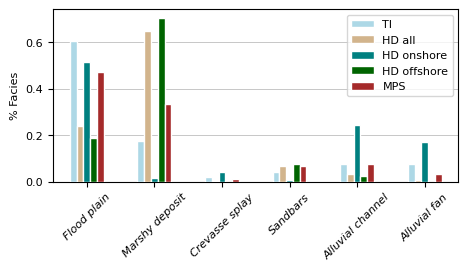

In [55]:
faciesNames  = ['Flood plain', 'Marshy deposit', 'Crevasse splay', 'Sandbars',  'Alluvial channel', 'Alluvial fan']
color_simply = ['lightblue','tan','teal','darkgreen','brown']


cm = 1/2.54  # centimeters in inches

plt.rcParams.update({'font.size': 8})

fig = plt.figure(figsize=(12*cm, 7*cm))
ax  = fig.add_subplot(111)

#On utilise la fonction plot inherente à pandas:
df_proportion.plot(kind='bar', ax=ax, color=color_simply, zorder=3, edgecolor='w') #zorder=3 pour mettre les bars devant le grid
#Paramètres pour l'affichage du plot:
plt.grid(True, axis='y', linewidth=0.5, zorder=0)                         #zorder=0 pour mettre le grid derrière les bars
plt.xticks([0,1,2,3,4,5], faciesNames, rotation=45, fontstyle = 'oblique') #renomme les ticks de l'axe des x
plt.ylabel('% Facies') #y label  
#plt.legend()     #bbox = coordoonée dans le grid, loc = point d'encrage de la legend             
plt.tight_layout()   
plt.savefig('99_images/thesis_image/pourcent_facies_simu.pdf', bbox_inches='tight')          #on sauvegarde la figure
plt.show()

In [56]:
plt.hist(get_histoHD(hd_runs,[5]*6))

NameError: name 'hd_runs' is not defined

# Calculate dissimilarity

In [ ]:

def distance_clark(refDistr, compareDistr):
    #Clark distanced (normalized euclidian distance)
    
    a = np.abs(refDistr -compareDistr)
    b = refDistr + compareDistr
    print(a,b)
    c = (a/b)**2
    d = np.nan_to_num(c)
    distance = np.sqrt(np.sum(d))
    
    return distance